# 1. Get data

In [ ]:
import kagglehub

path = kagglehub.dataset_download("ashkhagan/figshare-brain-tumor-dataset")

print("Path to dataset files:", path)

# 2. Export from matlab

Dataset Shapes:
X_tumor: (3064, 256, 256, 1)
Y_tumor_mask: (3064, 256, 256, 1)
Tumor Labels: (3064,)
Unique Labels: [0 1 2]


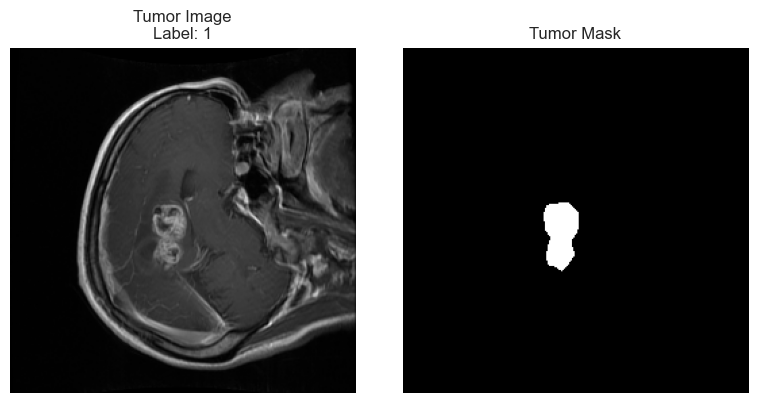

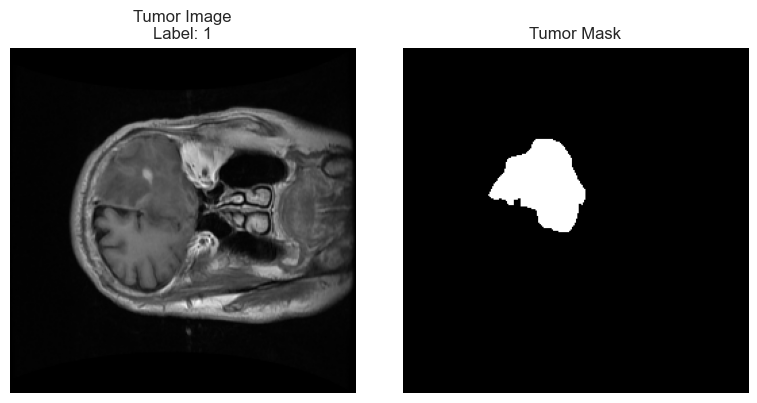

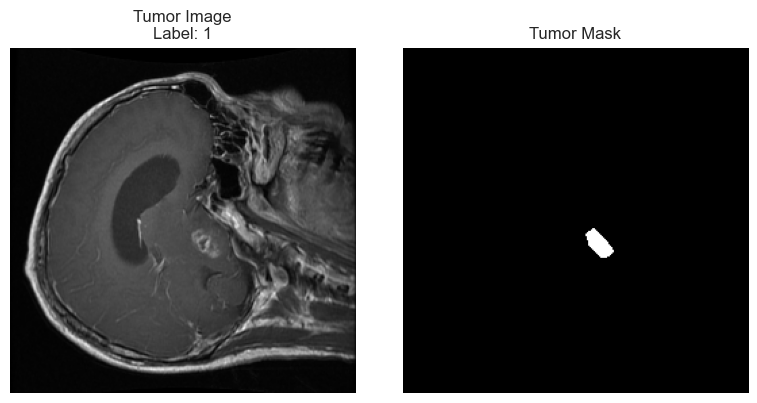

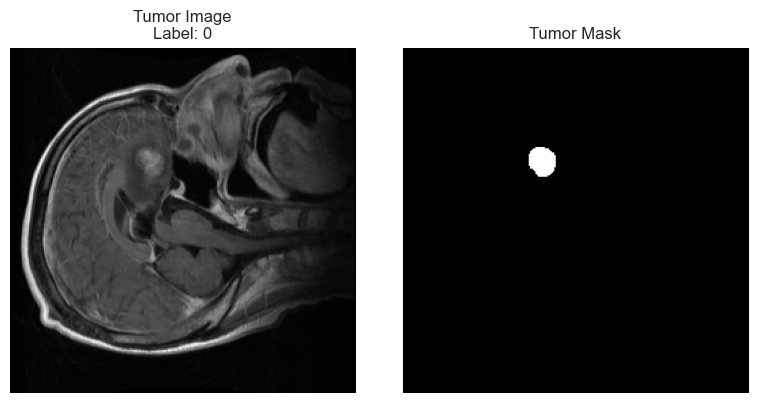

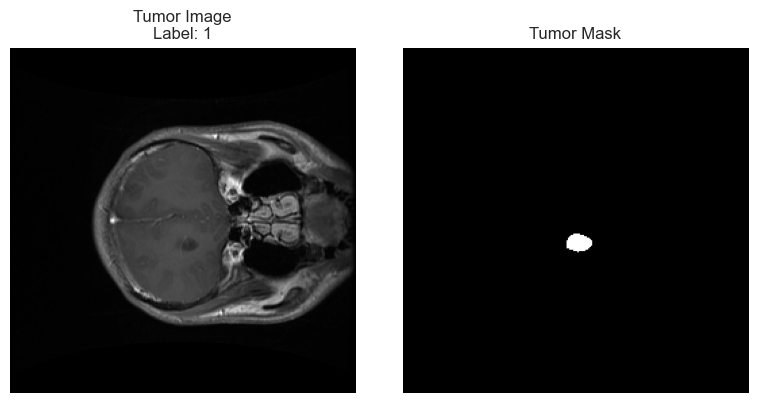

In [1]:
import random
import numpy as np
import h5py
import os
import cv2
import matplotlib.pyplot as plt

# path to dataset
# data_dir = "D:\\BACHELOR THESIS\\dataset\\ashkhagan\\figshare-brain-tumor-dataset\\versions\\1\\dataset\\data" # pt windows
data_dir = "/Users/horiaionescu/.cache/kagglehub/datasets/ashkhagan/figshare-brain-tumor-dataset/versions/1/dataset/data" # pt mac
total_images = 3064

X_tumor = []
Y_tumor_mask = []
tumor_labels = []


for i in range(1, total_images + 1):
    filename = str(i) + ".mat"
    file_path = os.path.join(data_dir, filename)

    # mat file using h5py (for matlab v7.3 files)
    with h5py.File(file_path, "r") as data:
        # image resize and normalize
        image = np.array(data["cjdata"]["image"])
        image = cv2.resize(image, (256, 256))  # 256x256
        image = image / 255.0  # normalize pixel val to be [0,1]
        X_tumor.append(image)

        # same goes for mask resize and threshold into binary img
        mask = np.array(data["cjdata"]["tumorMask"])
        mask = cv2.resize(mask, (256, 256))
        mask = (mask > 0).astype(np.uint8)  # this is conversion to binary img
        Y_tumor_mask.append(mask)

        # tumor label 1 -> meningioma  2 -> glioma  3 -> pituitary
        label = int(np.array(data["cjdata"]["label"])[0][0] - 1)
        tumor_labels.append(label)

# lists to numpy arr
# add extra channel dimension for compatibility with most deep learning models , this is grayscale
X_tumor = np.array(X_tumor).reshape(-1, 256, 256, 1)
Y_tumor_mask = np.array(Y_tumor_mask).reshape(-1, 256, 256, 1)
tumor_labels = np.array(tumor_labels)


print("Dataset shapes:")
print("X_tumor:", X_tumor.shape)
print("Y_tumor_mask:", Y_tumor_mask.shape)
print("Tumor labels:", tumor_labels.shape)
print("Unique labels:", np.unique(tumor_labels))


# visualize

num_samples = 5

sample_indices = random.sample(range(len(X_tumor)), num_samples)

for idx in sample_indices:
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(X_tumor[idx].squeeze(), cmap='gray')
    plt.title(f"Tumor Image\nLabel: {tumor_labels[idx]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(Y_tumor_mask[idx].squeeze(), cmap='gray')
    plt.title("Tumor Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


# 256x256x1 needed for segmentation
# for classification, we'll need 256x256x3 , 3 channel rgb

# 3. Preprocess

Processed X_tumor shape: (3064, 256, 256, 1)


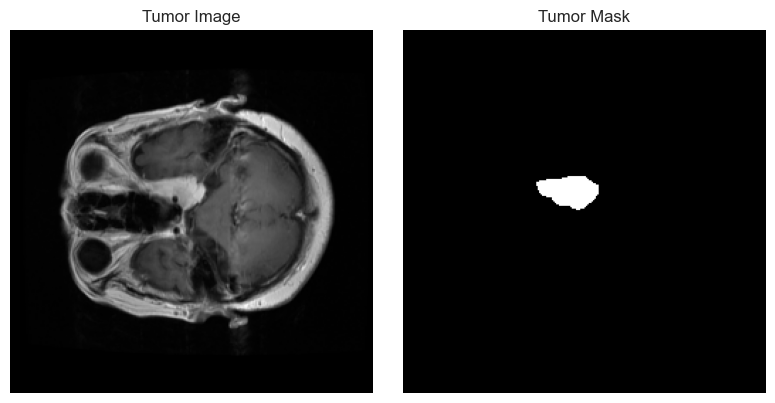

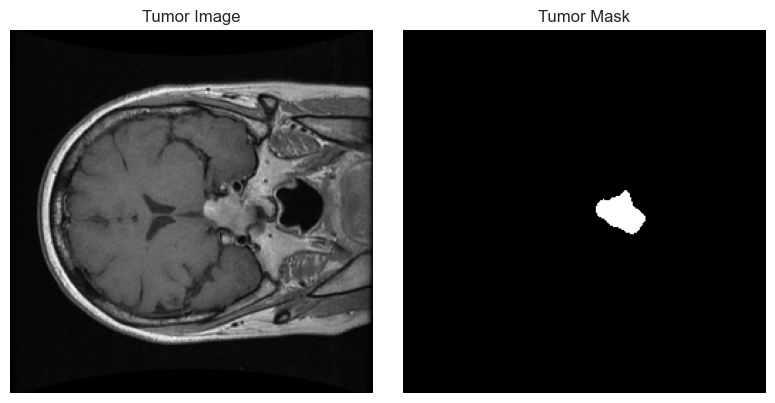

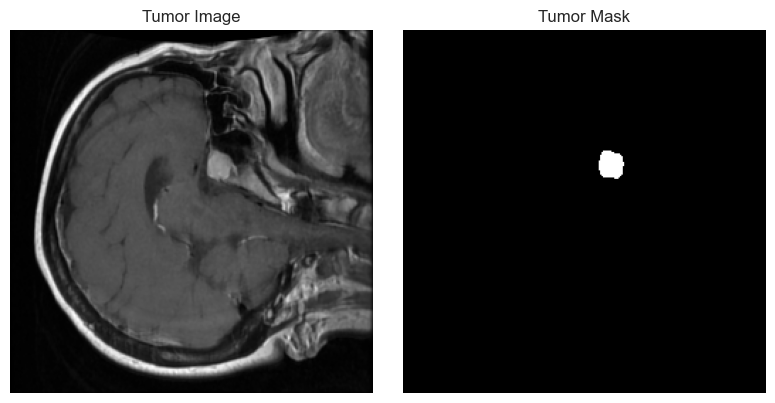

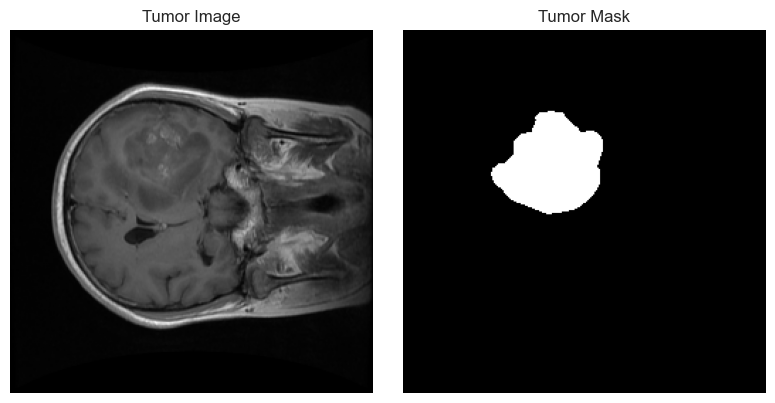

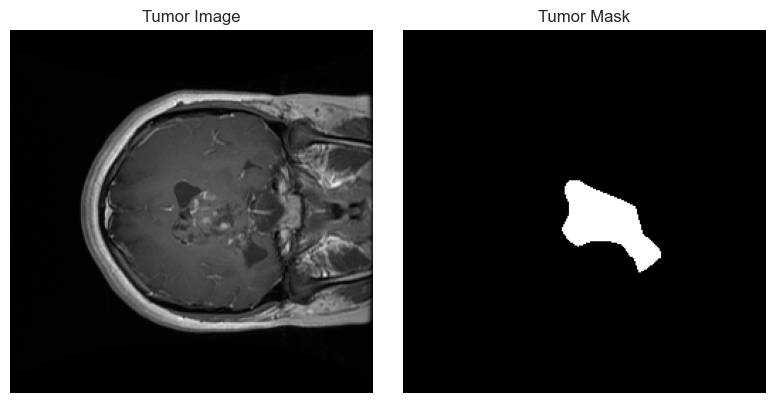

In [2]:
# resize 256x256x1 already done
# normalization already done
# grayscale as well, here we just do a check to ensure all are greyscale
# and padding to ensure uniformity

target_height = 256
target_width = 256

def check_and_pad(image, target_height, target_width):
    current_height, current_width = image.shape[:2]

    # return if image is already in required measurements
    if current_height == target_height and current_width == target_width:
        return image

    # padding calc
    pad_height = target_height - current_height
    pad_width = target_width - current_width

    if image.ndim == 3:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width), (0, 0)), mode='constant', constant_values=0)
    else:
        padded_image = np.pad(image, ((0, pad_height), (0, pad_width)), mode='constant', constant_values=0)
    return padded_image


X_tumor_processed = []


for img in X_tumor:
    # convert to grayscale in case it doesnt have enough channels
    if img.ndim == 3 and img.shape[-1] != 1:
        # convert from [0,1] to [0,255] for cv2 manipulation
        img_8bit = (img * 255).astype(np.uint8)
        img_gray = cv2.cvtColor(img_8bit, cv2.COLOR_BGR2GRAY)
        # go back to [0,1] and expand dimensions to add channel dimension
        img_gray = img_gray.astype(np.float32) / 255.0
        img = np.expand_dims(img_gray, axis=-1)

    img_2d = img.squeeze()
    img_padded = check_and_pad(img_2d, target_height, target_width)
    img_final = np.expand_dims(img_padded, axis=-1)
    X_tumor_processed.append(img_final)

X_tumor_processed = np.array(X_tumor_processed)
print("Processed X_tumor shape:", X_tumor_processed.shape)

# 4. Pytorch lightning module

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl

# dataset class
class BrainTumorDataset(Dataset):
    def __init__(self, images, masks, labels, transform=None):
        """
        images -> numpy array of shape (N, 256, 256, 1)
        masks -> numpy array of shape (N, 256, 256, 1)
        images and masks have same shape (and should have)
        labels -> numpy array of shape (N,)
        """
        self.images = images
        self.masks = masks
        self.labels = labels  # added for classification
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # # make images, masks and labels torch tensors and squeeze channel dim if necessary
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1)
        mask = torch.tensor(self.masks[idx], dtype=torch.float32).permute(2, 0, 1)
        label = self.labels[idx]  # 0, 1, 2

        return image, mask, label


    # Lightning dataModule
class BrainTumorDataModule(pl.LightningDataModule):
    def __init__(self, images, masks, labels, batch_size=16, val_split=0.1, test_split=0.2, num_workers=0):
        super().__init__()
        self.images = images
        self.masks = masks
        self.labels = labels  # added labels here
        self.batch_size = batch_size
        self.val_split = val_split
        self.test_split = test_split
        self.num_workers = num_workers

    def setup(self, stage=None):
        # create the full version of the dataset, now includes labels
        full_dataset = BrainTumorDataset(self.images, self.masks, self.labels)
        dataset_size = len(full_dataset)

        # split sizes
        test_size = int(self.test_split * dataset_size)
        val_size = int(self.val_split * (dataset_size - test_size))
        train_size = dataset_size - test_size - val_size

        # use generator with seed to ensure same items every run
        gen = torch.Generator().manual_seed(42)

        # this randomly splits the dataset
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size],
            generator = gen
        )
        print(f"Train size: {train_size}, Val size: {val_size}, Test size: {test_size}")

    # this will be used for training
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          shuffle=True, num_workers=self.num_workers)

    # .... for validation
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)

    # .... for testing
    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                          shuffle=False, num_workers=self.num_workers)


# instantiate data module, batch size already set
data_module = BrainTumorDataModule(X_tumor_processed, Y_tumor_mask, tumor_labels)
data_module.setup()

# initialize loaders
train_loader = data_module.train_dataloader()
test_loader = data_module.test_dataloader()
for batch in train_loader:
    images, masks, labels = batch  # technically, it should also include labels
    print("Batch images shape:", images.shape)  # should be (batch_size, 1, 256, 256)
    print("Batch masks shape:", masks.shape)    # same here
    print("Batch labels shape:", labels.shape)  # should be (batch_size,)
    break

# this shows how many samples from the test set are for each type of tumor
from collections import Counter
label_counts = Counter()

for images, masks, labels in test_loader:
    label_counts.update(labels.numpy())

for label in sorted(label_counts):
    print(f'Label {label} has {label_counts[label]} images in test set.')

Train size: 2207, Val size: 245, Test size: 612
Batch images shape: torch.Size([16, 1, 256, 256])
Batch masks shape: torch.Size([16, 1, 256, 256])
Batch labels shape: torch.Size([16])
Label 0 has 153 images in test set.
Label 1 has 281 images in test set.
Label 2 has 178 images in test set.


# 5. Model joint training

In [4]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

# setting seed again to ensure everything is the same every run !!!!!!
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
pl.seed_everything(42)
torch.cuda.manual_seed_all(42)  # for gpu usage
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# model
class FCNResNet50Lightning(pl.LightningModule):
    def __init__(
            self,
            num_seg_classes: int = 1,
            num_cls_classes: int = 3,
            lr: float = 1e-3,
            seg_weight: float = 0.75,    # weight for segmentation loss
            cls_weight: float = 0.25,    # weight for classification loss
            bce_weight: float = 0.5,
            dice_weight: float = 0.5
    ):
        super().__init__()
        self.save_hyperparameters()

        # load pretrained model and adjust everything similar to part2
        self.model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
        self.model.classifier[4] = nn.Conv2d(512, num_seg_classes, kernel_size=1)
        if hasattr(self.model, 'aux_classifier'):
            self.model.aux_classifier[4] = nn.Conv2d(256, num_seg_classes, kernel_size=1)

        self.bce_loss_fn = nn.BCEWithLogitsLoss()

        # classification head
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(512, num_cls_classes)
        )
        self.cls_loss_fn = nn.CrossEntropyLoss()

        self.seg_weight = seg_weight
        self.cls_weight = cls_weight

    def forward(self, x):
        # same explanation as in part 1 and 2
        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)

        # get features
        features = self.model.backbone(x)['out']

        seg_logits = self.model.classifier(features)
        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        class_logits = self.classifier(features)

        return seg_logits, class_logits

    def dice_loss(self, probs, targets, epsilon=1e-6):
        inter = (probs * targets).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets.sum(dim=(2, 3))
        dice  = 2.0 * inter / (union + epsilon)
        return 1 - dice.mean()

    def combined_seg_loss(self, logits, masks):
        bce   = self.bce_loss_fn(logits, masks)
        probs = torch.sigmoid(logits)
        dice  = self.dice_loss(probs, masks)
        return self.hparams.bce_weight * bce + self.hparams.dice_weight * dice

    def training_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        # loss calc with weights
        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        # final loss
        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss

        self.log('train_seg_loss', seg_loss, prog_bar=True)
        self.log('train_cls_loss', cls_loss, prog_bar=True)
        self.log('train_loss', total_loss, prog_bar=True)
        return total_loss

    def validation_step(self, batch, batch_idx):
        images, masks, labels = batch
        seg_logits, class_logits = self(images)

        seg_loss = self.combined_seg_loss(seg_logits, masks)
        cls_loss = self.cls_loss_fn(class_logits, labels)

        total_loss = self.seg_weight * seg_loss + self.cls_weight * cls_loss

        self.log('val_seg_loss', seg_loss, prog_bar=True)
        self.log('val_cls_loss', cls_loss, prog_bar=True)
        self.log('val_loss', total_loss, prog_bar=True)
        return total_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


Seed set to 42


# 6. Train

In [7]:
# initialize model, trainer, then train again for 10 epochs
model = FCNResNet50Lightning()
trainer = pl.Trainer(max_epochs=10)
trainer.fit(model, datamodule=data_module)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Train size: 2207, Val size: 245, Test size: 612



  | Name        | Type              | Params | Mode 
----------------------------------------------------------
0 | model       | FCN               | 35.3 M | train
1 | bce_loss_fn | BCEWithLogitsLoss | 0      | train
2 | classifier  | Sequential        | 1.1 M  | train
3 | cls_loss_fn | CrossEntropyLoss  | 0      | train
----------------------------------------------------------
36.4 M    Trainable params
0         Non-trainable params
36.4 M    Total params
145.430   Total estimated model params size (MB)
171       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 138/138 [03:47<00:00,  0.61it/s, v_num=3, train_seg_loss=0.360, train_cls_loss=0.649, train_loss=0.432]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=3, train_seg_loss=0.279, train_cls_loss=0.488, train_loss=0.331, val_seg_loss=0.341, val_cls_loss=0.486, val_loss=0.378] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=3, train_seg_loss=0.175, train_cls_loss=0.183, train_loss=0.177, val_seg_loss=0.277, val_cls_loss=0.477, val_loss=0.327] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=3, train_seg_loss=0.218, train_cls_loss=0.140, train_loss=0.198, val_seg_loss=0.217, val_cls_loss=0.222, val_loss=0.218] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 138/138 [03:48<00:00,  0.60it/s, v_num=3, train_seg_loss=0.213, train_cls_loss=0.429, train_loss=0.

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 138/138 [03:56<00:00,  0.58it/s, v_num=3, train_seg_loss=0.207, train_cls_loss=0.127, train_loss=0.187, val_seg_loss=0.180, val_cls_loss=0.283, val_loss=0.206]


# 7. Validation and test loss

In [8]:
# validation and test losses
model.eval()

trainer.validate(model, datamodule=data_module)

print("\n")

model.test_step = model.validation_step

trainer.test(model, datamodule=data_module)

Train size: 2207, Val size: 245, Test size: 612
Validation DataLoader 0: 100%|██████████| 16/16 [00:07<00:00,  2.05it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_cls_loss           0.282867431640625
        val_loss            0.20579682290554047
      val_seg_loss          0.18010662496089935
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.




Train size: 2207, Val size: 245, Test size: 612
Testing DataLoader 0: 100%|██████████| 39/39 [00:20<00:00,  1.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val_cls_loss          0.39206188917160034
        val_loss            0.22556471824645996
      val_seg_loss          0.17006567120552063
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_seg_loss': 0.17006567120552063,
  'val_cls_loss': 0.39206188917160034,
  'val_loss': 0.22556471824645996}]

# 8. Dice coefficient

In [9]:
model.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, *_ in test_loader:
        imgs  = imgs.to(model.device)
        masks = masks.to(model.device)
        seg_out, _ = model(imgs)
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Part 3 dice coef at threshold of 0.65:", sum(dice_scores)/len(dice_scores))

Part 3 Dice @0.65: 0.710551706644205


# 9. Classification report

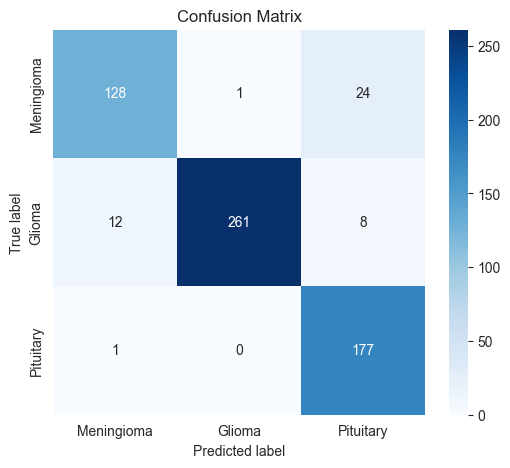

Classification Report:

              precision    recall  f1-score   support

  Meningioma     0.9078    0.8366    0.8707       153
      Glioma     0.9962    0.9288    0.9613       281
   Pituitary     0.8469    0.9944    0.9147       178

    accuracy                         0.9248       612
   macro avg     0.9170    0.9199    0.9156       612
weighted avg     0.9307    0.9248    0.9251       612



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, masks, labels in test_loader:
        # move to same device as model
        images = images.to(model.device)
        labels = labels.to(model.device)

        seg_logits, class_logits = model(images)  # get both logits

        preds = torch.argmax(class_logits, 1)  # for cls needed now

        y_true.append(labels.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
class_names = ["Meningioma", "Glioma", "Pituitary"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion Matrix")
plt.show()

# accuracy, precision, recall, f1
print("Classification Report:\n")
print(classification_report(
    y_true, y_pred,
    target_names=class_names,
    digits=4
))


# 10. Combined output

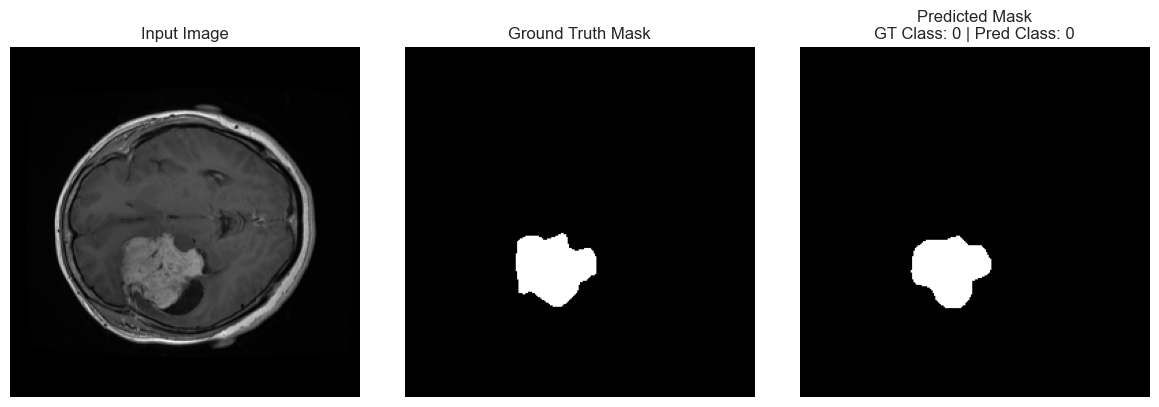

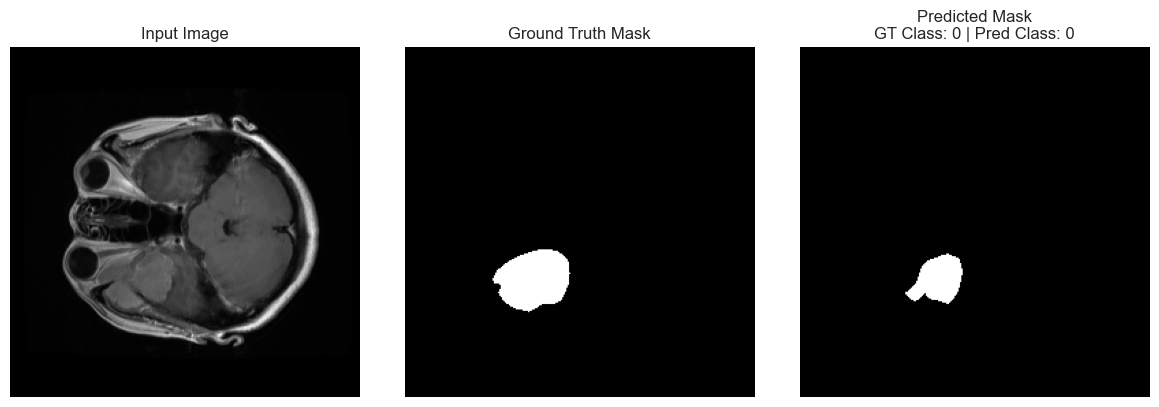

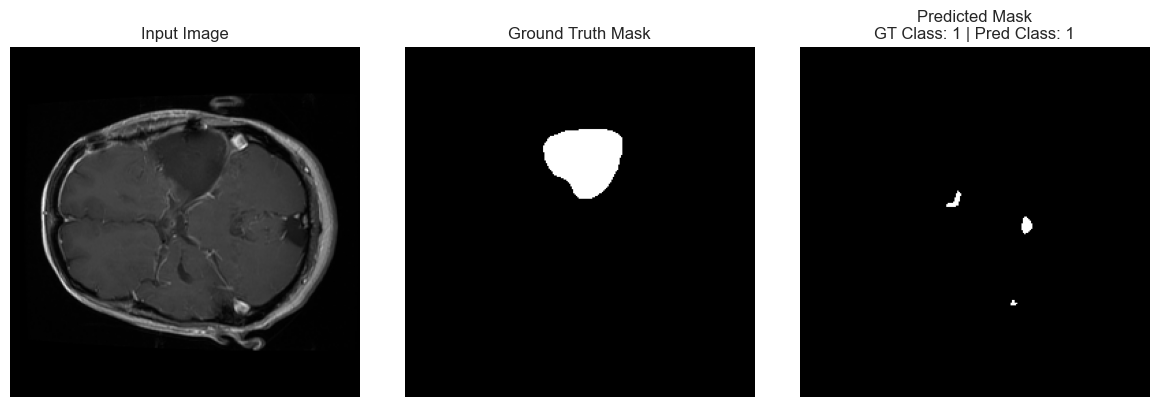

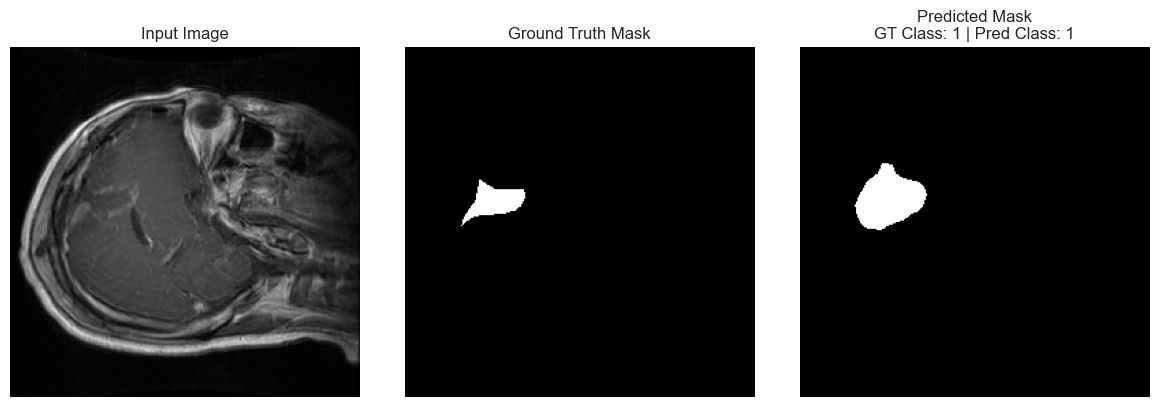

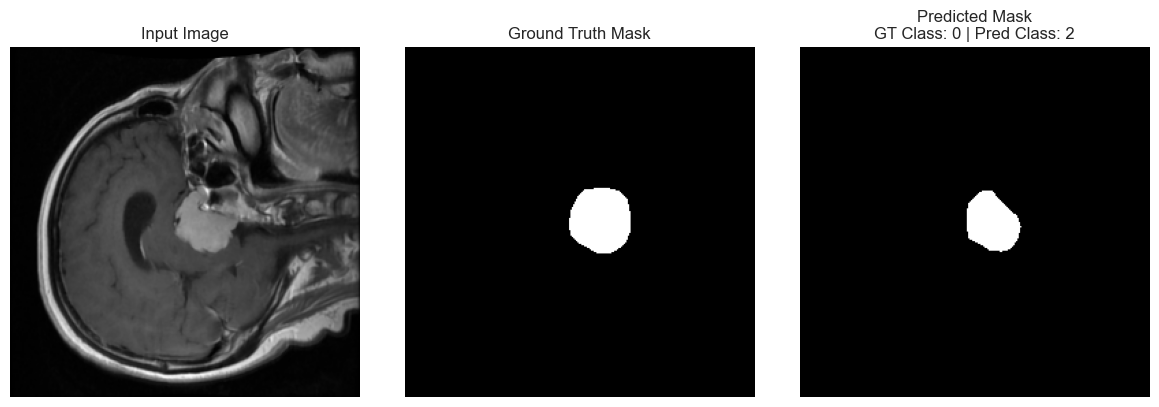

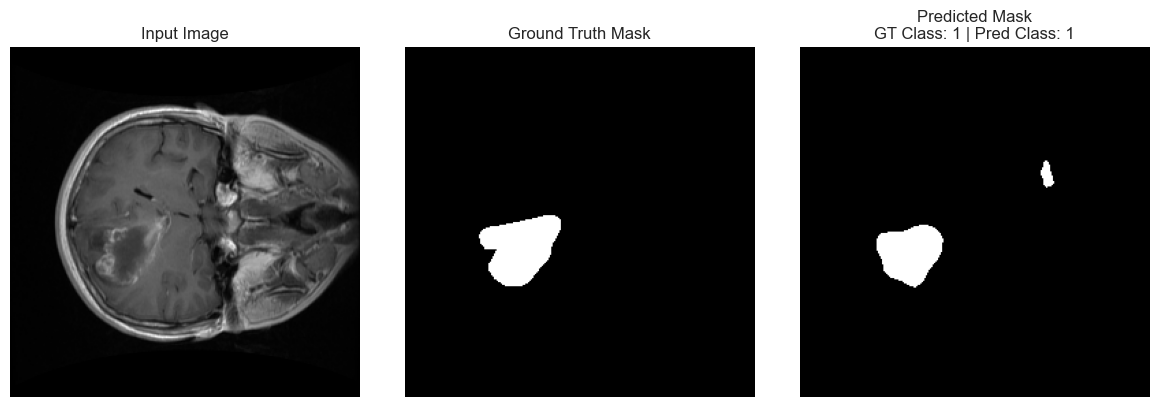

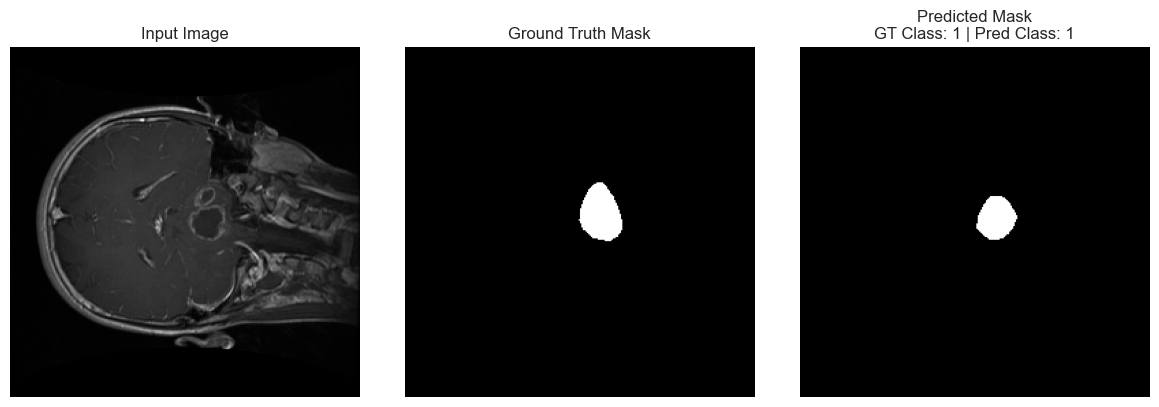

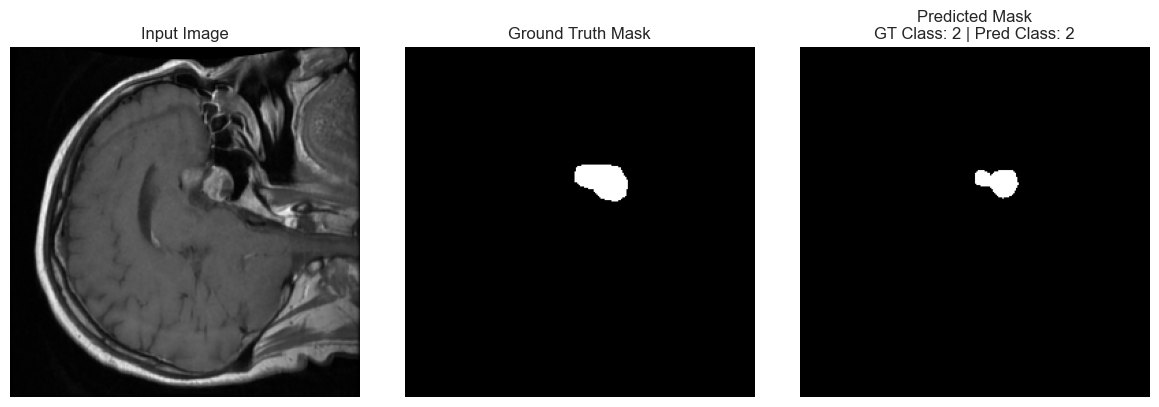

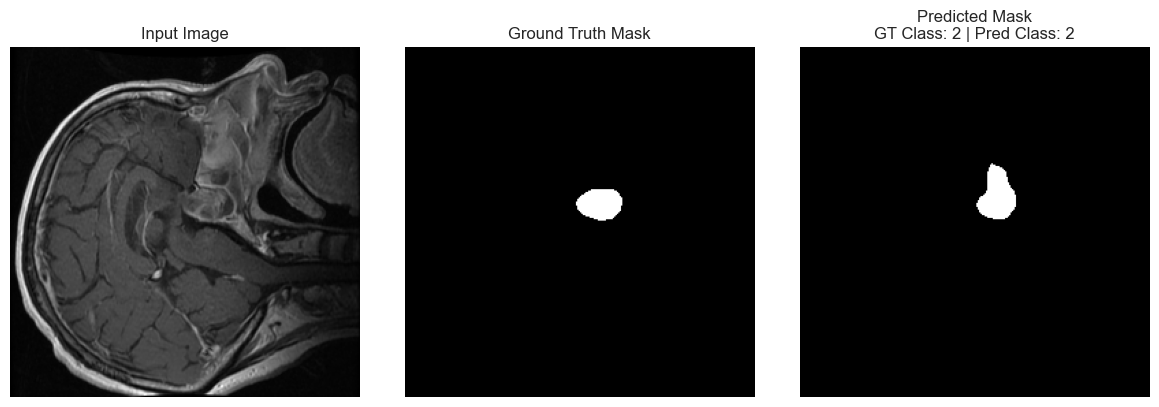

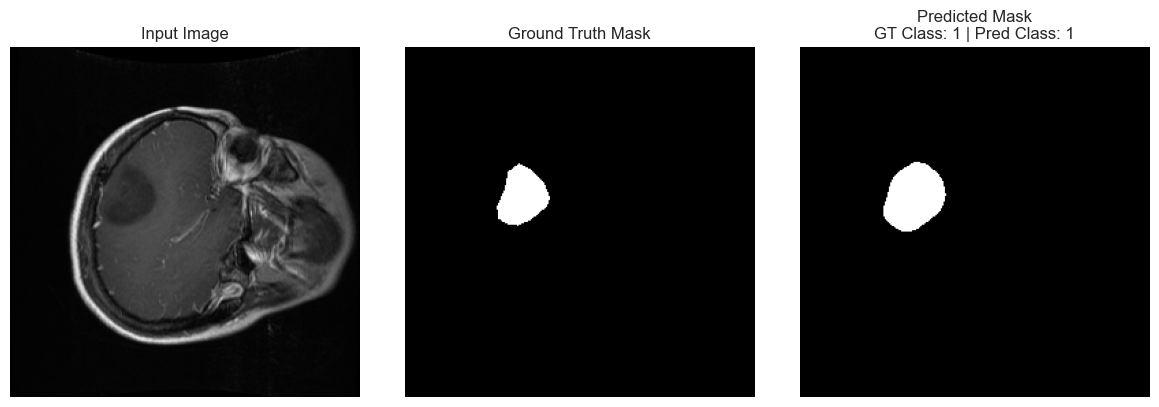

In [11]:
from tqdm import tqdm

model.eval()

all_images = []
all_masks = []
all_seg_preds = []
all_true_labels = []
all_pred_labels = []

with torch.no_grad():
    for images, masks, labels in tqdm(test_loader, desc="Collecting test examples"):
        seg_out, class_out = model(images)

        seg_out = F.interpolate(                      # same upsampling
            seg_out,
            size=masks.shape[2:],
            mode="bilinear",
            align_corners=False
        )

        pred_labels = torch.argmax(class_out, dim=1)

        all_images.append(images)
        all_masks.append(masks)
        all_seg_preds.append(seg_out)
        all_true_labels.append(labels)
        all_pred_labels.append(pred_labels)

all_images = torch.cat(all_images, dim=0)
all_masks = torch.cat(all_masks, dim=0)
all_seg_preds = torch.cat(all_seg_preds, dim=0)
all_true_labels = torch.cat(all_true_labels, dim=0)
all_pred_labels = torch.cat(all_pred_labels, dim=0)


num_samples = 10
indices = torch.randperm(all_images.shape[0])[:num_samples]

for idx in indices:
    image = all_images[idx].cpu().numpy().squeeze()
    mask = all_masks[idx].cpu().numpy().squeeze()
    seg_pred = all_seg_preds[idx].cpu().numpy().squeeze()

    seg_pred_bin = (seg_pred > 0.5).astype(float)

    true_label = all_true_labels[idx].item()
    pred_label = all_pred_labels[idx].item()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Input image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Ground truth mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(seg_pred_bin, cmap='gray')
    plt.title(f"Predicted mask\nGround truth class: {true_label} | Predicted class: {pred_label}")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Save model

In [12]:
trainer.save_checkpoint("checkpoints/0.71dice_0.92cls_part3.ckpt")

# make sure saved model has same performance

In [21]:
explainability = FCNResNet50Lightning.load_from_checkpoint("checkpoints/0.71dice_0.92cls_part3.ckpt")

explainability.eval()

def dice_coef(pred, target, thr=0.65, eps=1e-6):
    pred_bin = (pred > thr).float()
    B = pred_bin.shape[0]
    p_flat = pred_bin.view(B, -1)
    t_flat = target.view(B, -1)
    inter  = (p_flat * t_flat).sum(dim=1)
    summ   = p_flat.sum(dim=1) + t_flat.sum(dim=1)
    dice   = (2*inter + eps) / (summ + eps)
    return dice.mean().item()


dice_scores = []

with torch.no_grad():
    for imgs, masks, *_ in test_loader:
        imgs  = imgs.to(explainability.device)
        masks = masks.to(explainability.device)
        seg_out, _ = explainability(imgs)
        dice_scores.append(dice_coef(seg_out, masks, thr=0.65))

print("Part 3 Dice @0.65:", sum(dice_scores)/len(dice_scores))

# then, for classification for sure it's the same

Part 3 Dice @0.65: 0.710551706644205


# 11. Explainability for segmentation : Integrated Gradients

In [37]:
from captum.attr import Saliency, NoiseTunnel
import matplotlib.pyplot as plt
import numpy as np

device = next(explainability.parameters()).device
# Get one batch from test loader
x_batch, mask_batch, _ = next(iter(test_loader))
input_img = x_batch[0:1].to(device).detach()
gt_mask = mask_batch[0, 0].detach().cpu().numpy()  # Ground truth mask for first image
input_img.requires_grad_(True)

# Define segmentation score that preserves batch dim
def segmentation_score(inp: torch.Tensor) -> torch.Tensor:
    seg_logits, _ = explainability(inp)
    return seg_logits[:, 0, :, :].sum(dim=(1, 2))

# SmoothGrad setup
saliency = Saliency(segmentation_score)
nt = NoiseTunnel(saliency)
attributions = nt.attribute(
    inputs=input_img,
    nt_type='smoothgrad',
    stdevs=0.02,
    nt_samples=200,
)

# Process attributions
attr_map = attributions.squeeze(0).sum(dim=0).detach().cpu().numpy()
attr_map_norm = (attr_map - attr_map.min()) / (attr_map.max() - attr_map.min() + 1e-8)
inside_fraction = (np.sum(attr_map_norm * gt_mask) / (np.sum(attr_map_norm) + 1e-8)) * 100

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(input_img[0, 0].detach().cpu().numpy(), cmap='gray')
axes[0].set_title('MRI'); axes[0].axis('off')

axes[1].imshow(input_img[0, 0].detach().cpu().numpy(), cmap='gray')
axes[1].imshow(gt_mask, alpha=0.5, cmap='spring')
axes[1].set_title('GT Mask'); axes[1].axis('off')

axes[2].imshow(attr_map_norm, cmap='hot')
axes[2].set_title('SmoothGrad'); axes[2].axis('off')

axes[3].imshow(input_img[0, 0].detach().cpu().numpy(), cmap='gray')
axes[3].imshow(attr_map_norm, cmap='jet', alpha=0.5)
axes[3].set_title(f'Overlay (Inside: {inside_fraction:.1f}%)'); axes[3].axis('off')

plt.tight_layout()
plt.show()

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

<Figure size 1600x1200 with 0 Axes>

# 12. Explainability for Classification : GradCam

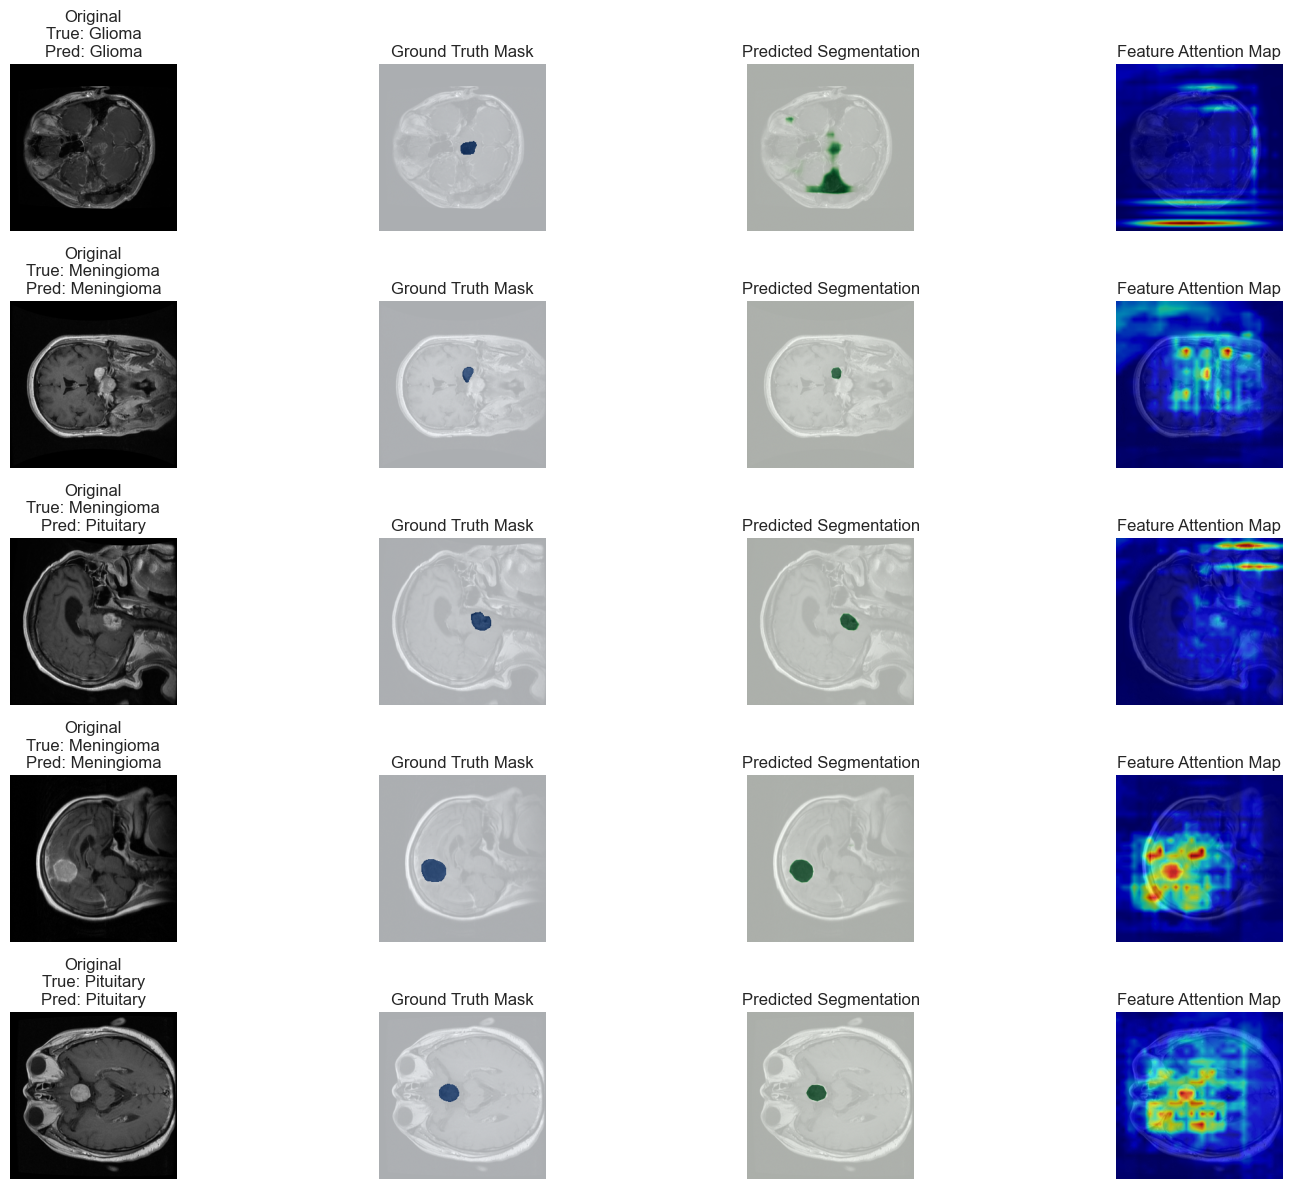

In [44]:
class ModifiedGradCAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.handles = []

        # Register hook to capture feature maps only
        self.handles.append(
            self.model.model.backbone.layer4.register_forward_hook(self._save_features)
        )

    def _save_features(self, module, input, output):
        self.feature_maps = output.detach()

    def remove_hooks(self):
        for handle in self.handles:
            handle.remove()

    def generate(self, image, target_class=None):
        # Make sure we're in eval mode
        self.model.eval()

        # Original forward pass to get class predictions
        with torch.no_grad():
            image_copy = image.clone()
            seg_logits, class_logits = self.model(image_copy)

            # If target class not specified, use the predicted class
            if target_class is None:
                target_class = torch.argmax(class_logits, dim=1)

        # Capture the feature maps using the hook
        self.feature_maps = None
        _ = self.model(image_copy)

        if self.feature_maps is None:
            raise RuntimeError("Failed to capture feature maps")

        # Create a mask for GradCAM - this is a simple feature importance approximation
        # For each feature map channel, compute its average value
        feature_importance = torch.mean(self.feature_maps, dim=[2, 3])

        # Create a weighted sum of feature maps (simplified GradCAM)
        B, C, H, W = self.feature_maps.shape

        # Create cam for each sample in batch
        cam_batch = []
        for b in range(B):
            # Create cam for this sample
            cam = torch.zeros((H, W), device=self.feature_maps.device)

            # Compute weighted feature maps for target class
            tc = target_class[b].item()

            # Using the feature map itself as an approximation since we can't backprop reliably
            weights = feature_importance[b]
            normalized_weights = F.softmax(weights, dim=0)

            # Apply weights to each feature map
            for c in range(C):
                cam += normalized_weights[c] * self.feature_maps[b, c]

            # Apply ReLU
            cam = F.relu(cam)
            cam_batch.append(cam)

        # Stack back into a batch
        cam_batch = torch.stack(cam_batch).unsqueeze(1)  # [B, 1, H, W]

        # Resize to match input size
        cam_batch = F.interpolate(cam_batch, size=image.shape[2:], mode='bilinear', align_corners=False)

        # Normalize
        for b in range(B):
            cam_batch[b] = (cam_batch[b] - cam_batch[b].min()) / (cam_batch[b].max() - cam_batch[b].min() + 1e-8)

        return cam_batch

def visualize_modified_gradcam(model, data_loader, num_samples=5):
    mod_cam = ModifiedGradCAM(model)
    samples_seen = 0

    tumor_types = {0: "Meningioma", 1: "Glioma", 2: "Pituitary"}

    plt.figure(figsize=(16, 12))

    try:
        for images, masks, labels in data_loader:
            if samples_seen >= num_samples:
                break

            # Forward pass to get predictions (without tracking gradients)
            with torch.no_grad():
                seg_logits, class_logits = model(images)
                seg_probs = torch.sigmoid(seg_logits)
                class_preds = torch.argmax(class_logits, dim=1)

            # Generate modified GradCAM heatmaps
            cam = mod_cam.generate(images, class_preds)

            for i in range(min(images.shape[0], num_samples - samples_seen)):
                true_label = labels[i].item()
                pred_label = class_preds[i].item()

                # Get numpy versions for visualization
                image_np = images[i, 0].cpu().numpy()
                mask_np = masks[i, 0].cpu().numpy()
                seg_np = seg_probs[i, 0].cpu().numpy()
                cam_np = cam[i, 0].cpu().numpy()



                # Plot original image
                plt.subplot(num_samples, 4, samples_seen*4 + 1)
                plt.imshow(image_np, cmap='gray')
                plt.title(f"Original\nTrue: {tumor_types.get(true_label)}\nPred: {tumor_types.get(pred_label)}")
                plt.axis('off')

                # Plot ground truth mask
                plt.subplot(num_samples, 4, samples_seen*4 + 2)
                plt.imshow(image_np, cmap='gray')
                plt.imshow(mask_np, alpha=0.7, cmap='Blues')
                plt.title("Ground Truth Mask")
                plt.axis('off')

                # Plot predicted segmentation
                plt.subplot(num_samples, 4, samples_seen*4 + 3)
                plt.imshow(image_np, cmap='gray')
                plt.imshow(seg_np, alpha=0.7, cmap='Greens')
                plt.title("Predicted Segmentation")
                plt.axis('off')

                # Plot Modified GradCAM heatmap
                plt.subplot(num_samples, 4, samples_seen*4 + 4)
                plt.imshow(image_np, cmap='gray')
                plt.imshow(cam_np, alpha=0.7, cmap='jet')
                plt.title("Feature Attention Map")
                plt.axis('off')

                samples_seen += 1
                if samples_seen >= num_samples:
                    break
    finally:
        # Clean up hooks
        mod_cam.remove_hooks()

    plt.tight_layout()
    plt.savefig('modified_gradcam_analysis.png', dpi=300)
    plt.show()

# Usage
visualize_modified_gradcam(explainability, data_module.test_dataloader())

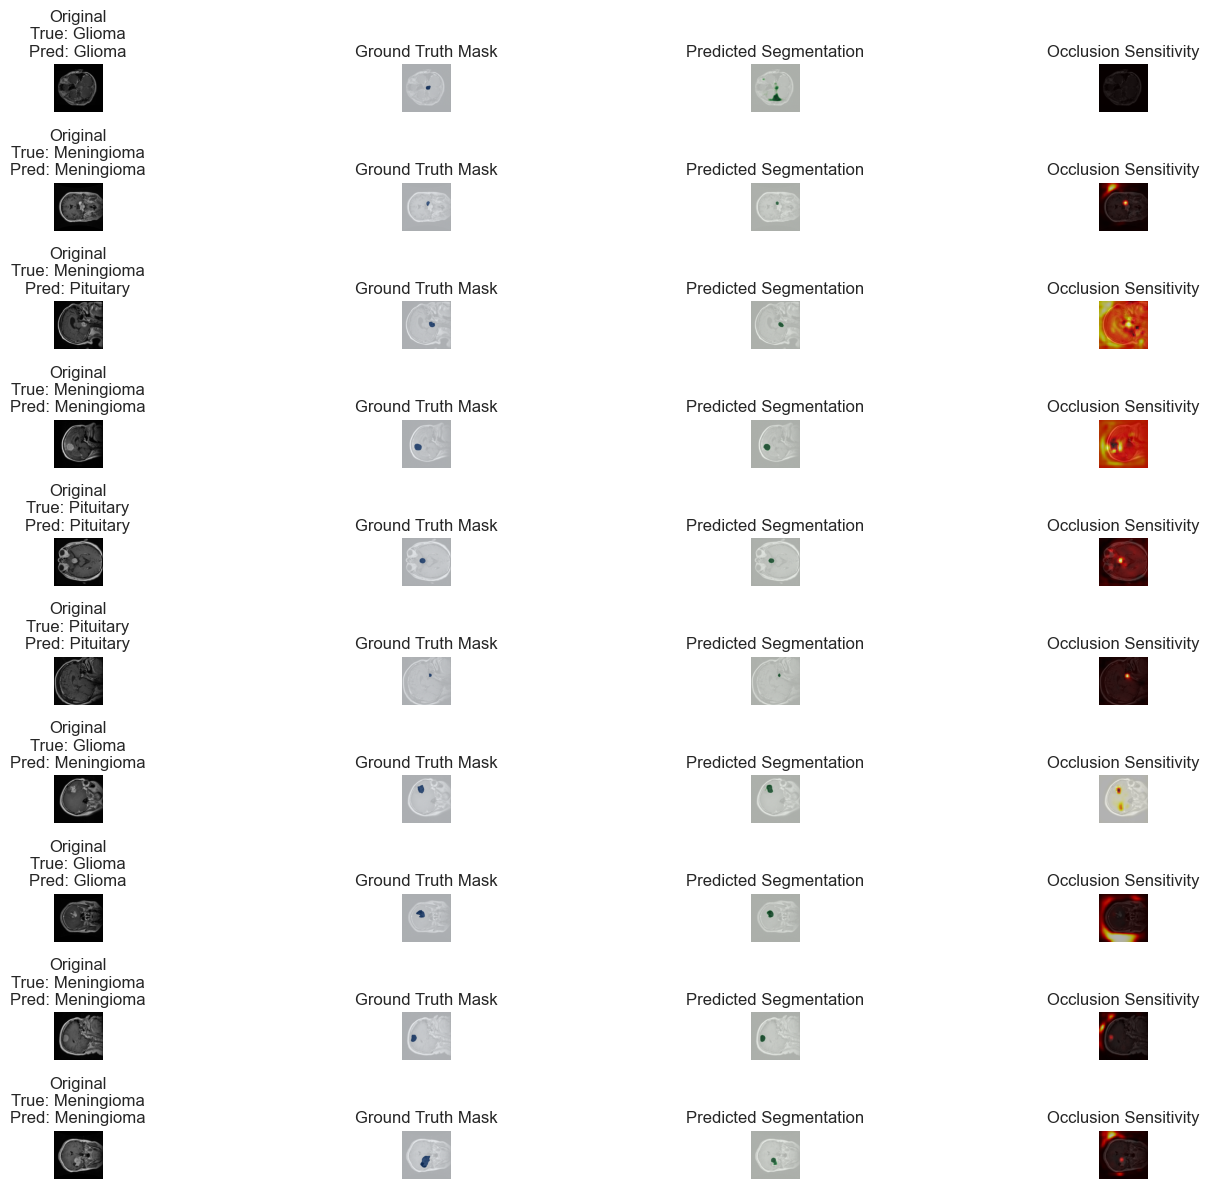

In [50]:
from scipy.ndimage import gaussian_filter

def occlusion_sensitivity(model, image, target_class,
                          mask_size=16, stride=8, fill_val=None):
    model.eval()
    B, C, H, W = image.shape
    device = image.device

    # original class probability
    with torch.no_grad():
        _, logits = model(image)
        orig_p = F.softmax(logits, dim=1)[0, target_class].item()

    impact = torch.zeros((H, W), device=device)
    count  = torch.zeros((H, W), device=device)

    # choose fill value = mean intensity if not provided
    if fill_val is None:
        fill_val = image.mean().item()

    for h in range(0, H - mask_size + 1, stride):
        for w in range(0, W - mask_size + 1, stride):
            img2 = image.clone()
            img2[:, :, h:h+mask_size, w:w+mask_size] = fill_val

            with torch.no_grad():
                _, logits2 = model(img2)
                p2 = F.softmax(logits2, dim=1)[0, target_class].item()

            diff = orig_p - p2
            impact[h:h+mask_size, w:w+mask_size] += diff
            count [h:h+mask_size, w:w+mask_size] += 1

    # average overlapping impacts
    sens_map = (impact / (count + 1e-8))
    # normalize to [0,1]
    sens_map = (sens_map - sens_map.min()) / (sens_map.max() - sens_map.min() + 1e-8)

    # optional smoothing
    sens_map = torch.from_numpy(
        gaussian_filter(sens_map.cpu().numpy(), sigma=2)
    ).to(device)

    return sens_map


def analyze_occlusion_sensitivity(model, data_loader, num_samples=10):
    model.eval()
    samples_seen = 0
    tumor_types = {0: "Meningioma", 1: "Glioma", 2: "Pituitary"}

    plt.figure(figsize=(16, 12))

    for images, masks, labels in data_loader:
        if samples_seen >= num_samples:
            break

        for i in range(min(images.shape[0], num_samples - samples_seen)):
            # Get occlusion sensitivity
            sensitivity_map = occlusion_sensitivity(
                model,
                images[i:i+1],
                labels[i].item()
            )

            # Get model predictions
            with torch.no_grad():
                seg_logits, class_logits = model(images[i:i+1])
                seg_probs = torch.sigmoid(seg_logits)
                pred_class = torch.argmax(class_logits, dim=1).item()

            # Convert to numpy for visualization
            image_np = images[i, 0].cpu().numpy()
            mask_np = masks[i, 0].cpu().numpy()
            seg_np = seg_probs[0, 0].cpu().numpy()
            sens_np = sensitivity_map.cpu().numpy()

            # Plot
            plt.subplot(num_samples, 4, samples_seen*4 + 1)
            plt.imshow(image_np, cmap='gray')
            plt.title(f"Original\nTrue: {tumor_types.get(labels[i].item())}\nPred: {tumor_types.get(pred_class)}")
            plt.axis('off')

            plt.subplot(num_samples, 4, samples_seen*4 + 2)
            plt.imshow(image_np, cmap='gray')
            plt.imshow(mask_np, alpha=0.7, cmap='Blues')
            plt.title("Ground Truth Mask")
            plt.axis('off')

            plt.subplot(num_samples, 4, samples_seen*4 + 3)
            plt.imshow(image_np, cmap='gray')
            plt.imshow(seg_np, alpha=0.7, cmap='Greens')
            plt.title("Predicted Segmentation")
            plt.axis('off')

            plt.subplot(num_samples, 4, samples_seen*4 + 4)
            plt.imshow(image_np, cmap='gray')
            plt.imshow(sens_np, alpha=0.7, cmap='hot')
            plt.title("Occlusion Sensitivity")
            plt.axis('off')

            samples_seen += 1
            if samples_seen >= num_samples:
                break

    plt.tight_layout()
    plt.savefig('occlusion_sensitivity.png', dpi=300)
    plt.show()

# Run on test set
analyze_occlusion_sensitivity(explainability, data_module.test_dataloader())